<a href="https://colab.research.google.com/github/DayenaJeong/FS_neuron/blob/main/FSneuron_poisson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def relu(x):
    return np.maximum(0, x)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def swish(x):
    return x * 1 / (1 + np.exp(-x))


def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))


def softplus(x, beta=1):
    return (1 / beta) * np.log(1 + np.exp(beta * x))


def mish(x, beta=1):
    return x * np.tanh(softplus(x, beta))

In [ ]:
# Implementation of spike function for PyTorch custom gradient
class SpikeFunction(autograd.Function):
    @staticmethod
    def forward(ctx, v_scaled):
        z_ = torch.where(v_scaled > 0, torch.ones_like(v_scaled), torch.zeros_like(v_scaled))
        ctx.save_for_backward(v_scaled)
        return z_

    @staticmethod
    def backward(ctx, grad_output):
        v_scaled, = ctx.saved_tensors
        dz_dv_scaled = torch.maximum(1 - torch.abs(v_scaled), torch.tensor(0.0, device=v_scaled.device))
        dE_dv_scaled = grad_output * dz_dv_scaled
        return dE_dv_scaled

# Call spike function for PyTorch
def spike_function(v_scaled):
    return SpikeFunction.apply(v_scaled)

# FS class definition
class FS(nn.Module):
    def __init__(self, num_params):
        super(FS, self).__init__()

        if num_params == 4:
              h = torch.tensor([6.0247, 3.0090, 1.5470, 1.0945])
              d = torch.tensor([6.1718, 3.0962, 1.5492, 0.7664])
              T = torch.tensor([5.8070, 2.8584, 1.3577, 0.5687])
        elif num_params == 8:
              h = torch.tensor([3.6760, 2.8168, 2.3811, 1.3095, 0.8152, 0.3878, 0.1751, 2.4152])
              d = torch.tensor([3.6922, 2.9805, 2.4332, 1.3228, 0.8048, 0.3861, 0.1863, 0.1023])
              T = torch.tensor([8.2595, 3.5255, 2.5539, 1.7761, 0.9528, 0.5461, 0.3573, 0.2881])
        elif num_params == 12:
              h = torch.tensor([1.1299, 6.8735, 4.4682, 2.0329, 1.3388, 0.7357, 0.7149, 0.4261, 0.6461, 0.4154, 0.2179, 0.3444])
              d = torch.tensor([-0.2083,  7.0264,  4.6516,  2.1096,  1.3740,  0.7480,  0.6828,  0.3809, 0.4077,  0.2240,  0.1159,  0.0536])
              T = torch.tensor([-3.5203,  5.9076,  4.0212,  1.8142,  0.9658,  0.3212, -0.0740, -0.4722, -0.7314, -1.2238, -1.3265, -1.4648])
        elif num_params == 16:
              h = torch.tensor([0.5602, 0.3329, 1.2282, 1.4916, 1.0170, 1.0777, 0.9202, 1.2722, 2.8685, 1.3212, 0.8411, 0.3989, 0.1870, 0.0936, 0.0616, 1.1349])
              d = torch.tensor([0.3161,  0.2175, -0.2093,  1.6195,  1.0840,  1.1121,  0.9249,  1.2900, 2.8708,  1.3277,  0.8375,  0.3912,  0.1875,  0.0973,  0.0640,  0.0406])
              T = torch.tensor([0.0984, -0.0835, -3.5130,  0.6933,  0.1460,  0.0137,  0.9415,  0.2020, 1.2894, -0.2560, -0.7142, -1.1954, -1.3832, -1.4649, -1.4901, -1.5134])

        # Add Poisson noise to parameters
        h_noise = torch.poisson(torch.full(h.size(), 0.1))
        d_noise = torch.poisson(torch.full(d.size(), 0.1))
        T_noise = torch.poisson(torch.full(T.size(), 0.1))

        self.h = nn.Parameter(h + h_noise.float())
        self.d = nn.Parameter(d + d_noise.float())
        self.T = nn.Parameter(T + T_noise.float())

    def forward(self, x):
        v = x.clone()

        # Initialize temporary output for FS spike neural network
        temp_out = torch.zeros_like(v)

        # Implement FS spike neural network
        for t in range(len(self.T)):
            #v_scaled = (v - self.T[t]) / (torch.abs(v) + 1)
            v_scaled = v - self.T[t]
            z = spike_function(v_scaled)
            temp_out += z * self.d[t]
            v = v - z * self.h[t]

        return temp_out

# Swish

K=4

Epoch 1/20000, Loss: 0.03879478946328163
Epoch 1001/20000, Loss: 0.038796089589595795
Epoch 2001/20000, Loss: 0.03879512846469879
Epoch 3001/20000, Loss: 0.03879518434405327
Epoch 4001/20000, Loss: 0.03879649564623833
Epoch 5001/20000, Loss: 0.03879591077566147
Epoch 6001/20000, Loss: 0.038795746862888336
Epoch 7001/20000, Loss: 0.038794226944446564
Epoch 8001/20000, Loss: 0.03879605606198311
Epoch 9001/20000, Loss: 0.03879496827721596
Epoch 10001/20000, Loss: 0.03879724070429802
Epoch 11001/20000, Loss: 0.038795679807662964
Epoch 12001/20000, Loss: 0.038796331733465195
Epoch 13001/20000, Loss: 0.03879601135849953
Epoch 14001/20000, Loss: 0.038795966655015945
Epoch 15001/20000, Loss: 0.038796715438365936
Epoch 16001/20000, Loss: 0.038795147091150284
Epoch 17001/20000, Loss: 0.03879609331488609
Epoch 18001/20000, Loss: 0.038796406239271164
Epoch 19001/20000, Loss: 0.038795311003923416
Loss values: [0.03879478946328163, 0.03879663720726967, 0.038797974586486816, 0.038796890527009964, 0.0

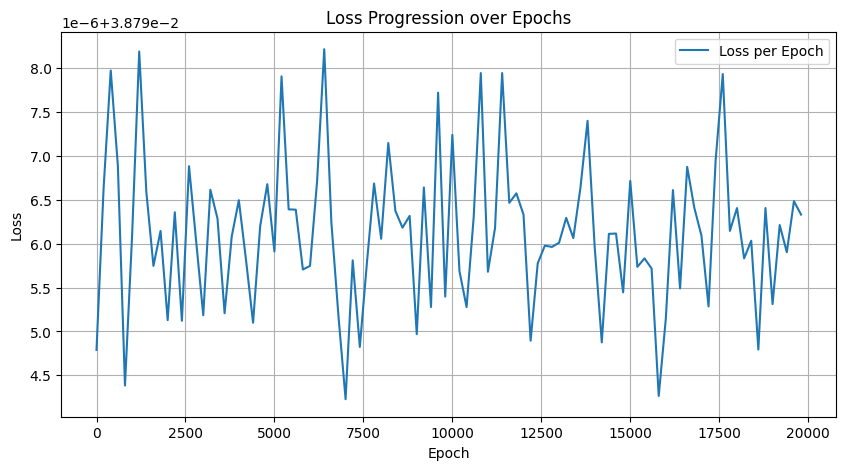

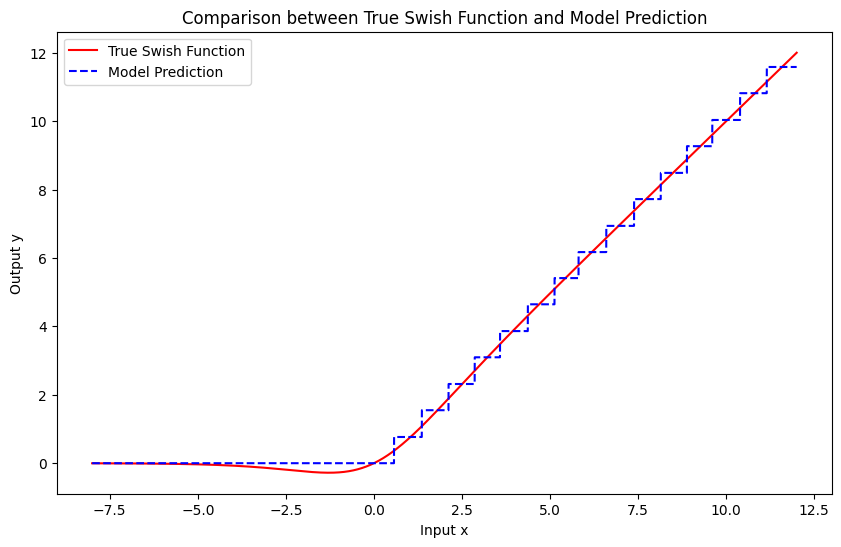

In [ ]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')


# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

K=8

Epoch 1/20000, Loss: 0.008968070149421692
Epoch 1001/20000, Loss: 0.008968239650130272
Epoch 2001/20000, Loss: 0.008968998678028584
Epoch 3001/20000, Loss: 0.008968260139226913
Epoch 4001/20000, Loss: 0.008968377485871315
Epoch 5001/20000, Loss: 0.00896843895316124
Epoch 6001/20000, Loss: 0.0089681725949049
Epoch 7001/20000, Loss: 0.008968674577772617
Epoch 8001/20000, Loss: 0.008968568406999111
Epoch 9001/20000, Loss: 0.008967951871454716
Epoch 10001/20000, Loss: 0.008968585170805454
Epoch 11001/20000, Loss: 0.008968294598162174
Epoch 12001/20000, Loss: 0.008968454785645008
Epoch 13001/20000, Loss: 0.008968336507678032
Epoch 14001/20000, Loss: 0.008968128822743893
Epoch 15001/20000, Loss: 0.008968639187514782
Epoch 16001/20000, Loss: 0.008968387730419636
Epoch 17001/20000, Loss: 0.008968470618128777
Epoch 18001/20000, Loss: 0.008968333713710308
Epoch 19001/20000, Loss: 0.008968640118837357
Loss values: [0.008968070149421692, 0.008968126960098743, 0.008968097157776356, 0.00896831415593

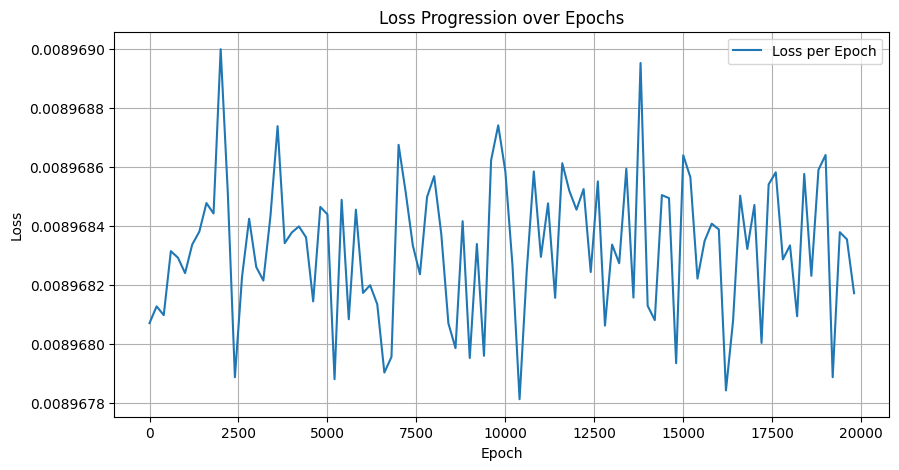

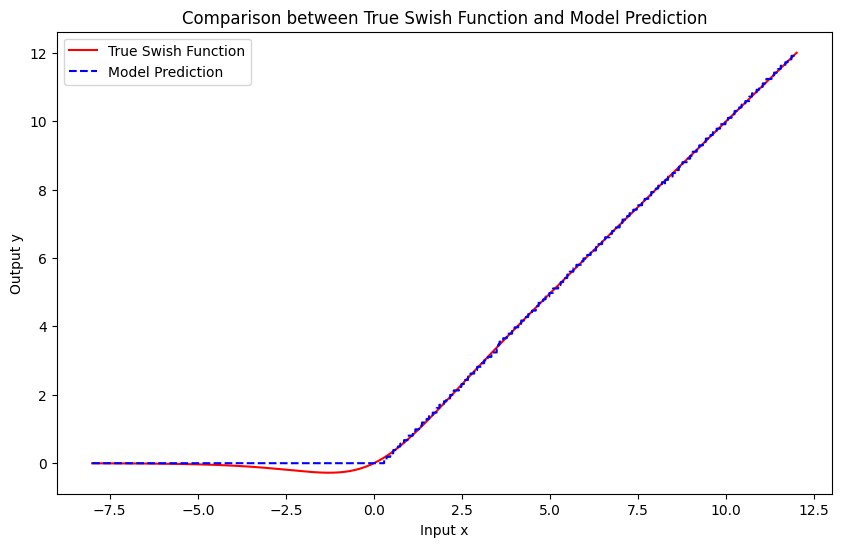

In [ ]:
# Instantiate model and initial setup
num_params = 8  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
#plt.xlabel('Input x')
#plt.ylabel('Output y')
plt.legend()

plt.show()

K=12

Epoch 1/20000, Loss: 1.001479983329773
Epoch 1001/20000, Loss: 0.014276805333793163
Epoch 2001/20000, Loss: 0.005400998517870903
Epoch 3001/20000, Loss: 0.003639490343630314
Epoch 4001/20000, Loss: 0.0027070934884250164
Epoch 5001/20000, Loss: 0.0025821628514677286
Epoch 6001/20000, Loss: 0.002724024932831526
Epoch 7001/20000, Loss: 0.002007606904953718
Epoch 8001/20000, Loss: 0.0021478559356182814
Epoch 9001/20000, Loss: 0.0021662802901118994
Epoch 10001/20000, Loss: 0.0019506813259795308
Epoch 11001/20000, Loss: 0.0018578462768346071
Epoch 12001/20000, Loss: 0.0017433965113013983
Epoch 13001/20000, Loss: 0.0016839875606819987
Epoch 14001/20000, Loss: 0.0016782095190137625
Epoch 15001/20000, Loss: 0.0015381657285615802
Epoch 16001/20000, Loss: 0.0015309692826122046
Epoch 17001/20000, Loss: 0.0015395383816212416
Epoch 18001/20000, Loss: 0.0015144943026825786
Epoch 19001/20000, Loss: 0.0015285654226318002
Loss values: [1.001479983329773, 0.1392887532711029, 0.0926905944943428, 0.0678143

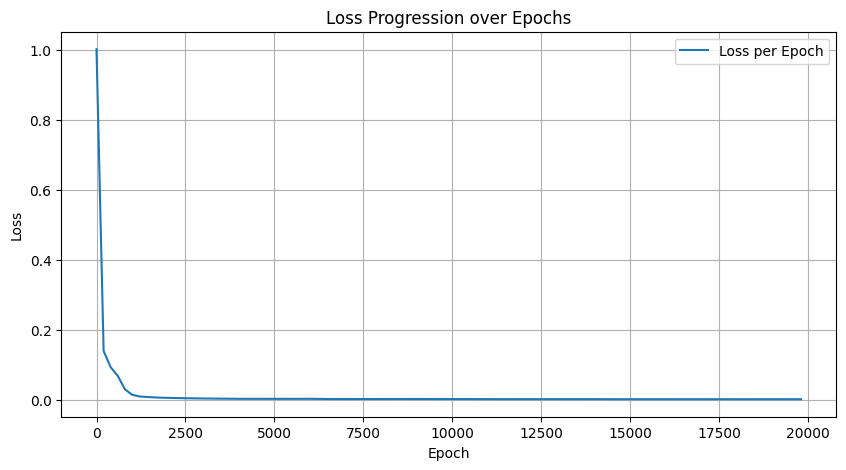

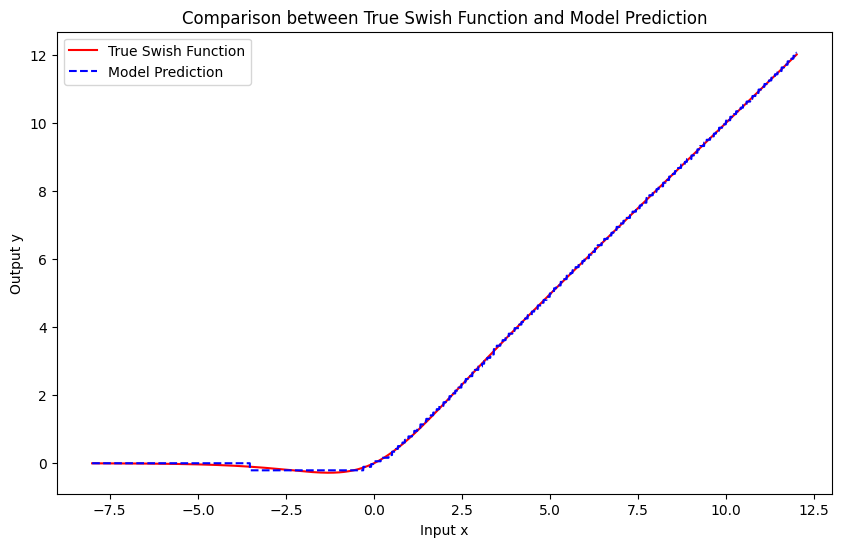

In [ ]:
# Instantiate model and initial setup
num_params = 12  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')


# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

K=16

Epoch 1/20000, Loss: 0.9598065614700317
Epoch 1001/20000, Loss: 0.01834098808467388
Epoch 2001/20000, Loss: 0.0036479022819548845
Epoch 3001/20000, Loss: 0.001687639974988997
Epoch 4001/20000, Loss: 0.0014118771068751812
Epoch 5001/20000, Loss: 0.0013314812676981091
Epoch 6001/20000, Loss: 0.0012929579243063927
Epoch 7001/20000, Loss: 0.001278124051168561
Epoch 8001/20000, Loss: 0.0012050223303958774
Epoch 9001/20000, Loss: 0.0011625264305621386
Epoch 10001/20000, Loss: 0.0011849197326228023
Epoch 11001/20000, Loss: 0.001192983239889145
Epoch 12001/20000, Loss: 0.001179638784378767
Epoch 13001/20000, Loss: 0.001165652647614479
Epoch 14001/20000, Loss: 0.001157582039013505
Epoch 15001/20000, Loss: 0.0011482483241707087
Epoch 16001/20000, Loss: 0.0011538189137354493
Epoch 17001/20000, Loss: 0.0011446564458310604
Epoch 18001/20000, Loss: 0.001146534807048738
Epoch 19001/20000, Loss: 0.0011185695184394717
Loss values: [0.9598065614700317, 0.12644720077514648, 0.07110555469989777, 0.0491445

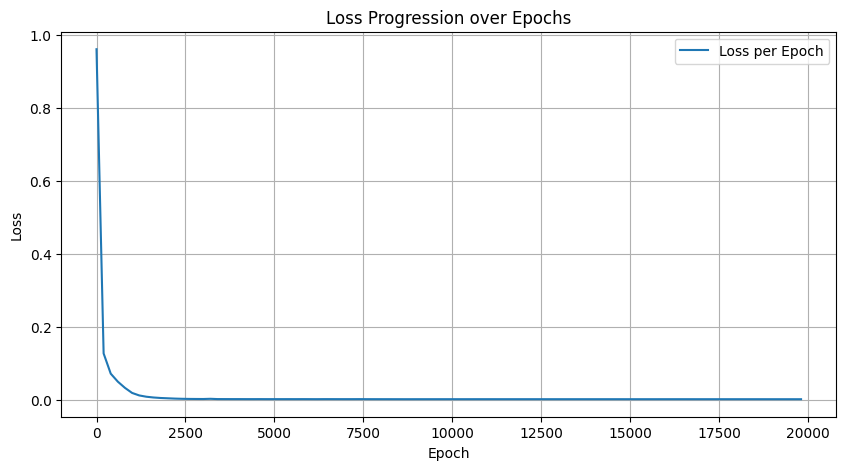

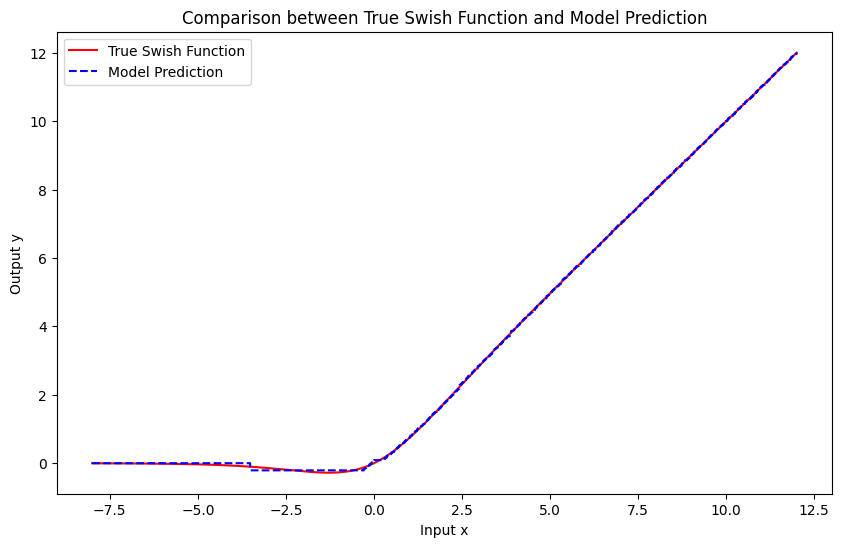

In [ ]:
# Instantiate model and initial setup
num_params = 16  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')


# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()